# Exercise 6: Overfitting, cross-validation and Nearest Neighbor

#### Objective: The objective of this exercise is to understand how cross-validation can be used to avoid overfitting as well as the k-nearest neighbor method.

### Task 6.1.1: Decision Tree Pruning Using Cross-Validation

In this task, we load the wine dataset and use cross-validation to prune a decision tree. We modify the maximum depth of the tree (from 2 to 20) and observe how it affects the classification error on both the training and test sets.

- **Objective**: Identify the optimal tree depth by analyzing the classification error as a function of pruning level. This helps avoid overfitting by controlling the complexity of the tree.

We will plot the classification error for both training and test sets and analyze how the tree's depth impacts the model’s generalization performance.

In [ ]:
# exercise 6.1.1

import importlib_resources
import numpy as np
from matplotlib.pylab import figure, legend, plot, show, xlabel, ylabel
from scipy.io import loadmat
from sklearn import model_selection, tree

filename = importlib_resources.files("dtuimldmtools").joinpath("data/wine2.mat")

# Load Matlab data file and extract variables of interest
mat_data = loadmat(filename)
X = mat_data["X"]
y = mat_data["y"].squeeze()
attributeNames = [name[0] for name in mat_data["attributeNames"][0]]
classNames = [name[0][0] for name in mat_data["classNames"]]
N, M = X.shape
C = len(classNames)

# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 21, 1)

# Simple holdout-set crossvalidation
test_proportion = 0.5
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=test_proportion
)

# Initialize variables
Error_train = np.empty((len(tc), 1))
Error_test = np.empty((len(tc), 1))

for i, t in enumerate(tc):
    # Fit decision tree classifier, Gini split criterion, different pruning levels
    dtc = tree.DecisionTreeClassifier(criterion="gini", max_depth=t)
    dtc = dtc.fit(X_train, y_train)

    # Evaluate classifier's misclassification rate over train/test data
    y_est_test = np.asarray(dtc.predict(X_test), dtype=int)
    y_est_train = np.asarray(dtc.predict(X_train), dtype=int)
    misclass_rate_test = sum(y_est_test != y_test) / float(len(y_est_test))
    misclass_rate_train = sum(y_est_train != y_train) / float(len(y_est_train))
    Error_test[i], Error_train[i] = misclass_rate_test, misclass_rate_train

f = figure()
plot(tc, Error_train * 100)
plot(tc, Error_test * 100)
xlabel("Model complexity (max tree depth)")
ylabel("Error (%)")
legend(["Error_train", "Error_test"])

show()

print("Ran Exercise 6.1.1")

- **Visualization**: The plot shows how the classification error varies with model complexity (tree depth). The optimal depth is where the test error is minimized without significantly increasing the training error.

-> By adjusting the tree's depth, we can observe how overfitting occurs with overly complex models and how a pruned tree generalizes better to unseen data.


### Task 6.1.2: Decision Tree Pruning Using 10-Fold Cross-Validation

In this task, we use 10-fold cross-validation to prune a decision tree. The dataset is split into 10 folds, and for each fold, the model is trained on 9 folds and tested on the remaining fold. This process is repeated for each fold, and the average classification error is computed.

- **Objective**: Compare the classification error across different tree depths using 10-fold cross-validation. This method provides a more robust estimate of the model’s generalization performance by averaging the error across multiple training and test splits.
- **Visualization**: We will plot the classification error as a function of the tree depth to identify the optimal depth that minimizes the test error without overfitting the training data.

This task provides a better understanding of how the model performs on unseen data by averaging the error across multiple splits.

In [ ]:
# exercise 6.1.2

import importlib_resources
import numpy as np
from matplotlib.pyplot import boxplot, figure, legend, plot, show, xlabel, ylabel
from scipy.io import loadmat
from sklearn import model_selection, tree

filename = importlib_resources.files("dtuimldmtools").joinpath("data/wine2.mat")
# Load Matlab data file and extract variables of interest
mat_data = loadmat(filename)
X = mat_data["X"]
y = mat_data["y"].squeeze()
attributeNames = [name[0] for name in mat_data["attributeNames"][0]]
classNames = [name[0][0] for name in mat_data["classNames"]]
N, M = X.shape
C = len(classNames)

# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 21, 1)

# K-fold crossvalidation
K = 10
CV = model_selection.KFold(n_splits=K, shuffle=True)

# Initialize variable
Error_train = np.empty((len(tc), K))
Error_test = np.empty((len(tc), K))

k = 0
for train_index, test_index in CV.split(X):
    print("Computing CV fold: {0}/{1}..".format(k + 1, K))

    # extract training and test set for current CV fold
    X_train, y_train = X[train_index, :], y[train_index]
    X_test, y_test = X[test_index, :], y[test_index]

    for i, t in enumerate(tc):
        # Fit decision tree classifier, Gini split criterion, different pruning levels
        dtc = tree.DecisionTreeClassifier(criterion="gini", max_depth=t)
        dtc = dtc.fit(X_train, y_train.ravel())
        y_est_test = dtc.predict(X_test)
        y_est_train = dtc.predict(X_train)
        # Evaluate misclassification rate over train/test data (in this CV fold)
        misclass_rate_test = np.sum(y_est_test != y_test) / float(len(y_est_test))
        misclass_rate_train = np.sum(y_est_train != y_train) / float(len(y_est_train))
        Error_test[i, k], Error_train[i, k] = misclass_rate_test, misclass_rate_train
    k += 1


f = figure()
boxplot(Error_test.T)
xlabel("Model complexity (max tree depth)")
ylabel("Test error across CV folds, K={0})".format(K))

f = figure()
plot(tc, Error_train.mean(1))
plot(tc, Error_test.mean(1))
xlabel("Model complexity (max tree depth)")
ylabel("Error (misclassification rate, CV K={0})".format(K))
legend(["Error_train", "Error_test"])

show()

print("Ran Exercise 6.1.2")

- **Visualization**:
  - A **boxplot** is used to display the distribution of test errors across the cross-validation folds for different tree depths.
  - A line plot shows the mean training and test errors as a function of tree depth.

-> This task allows us to observe how well the model generalizes with different tree depths, helping to avoid overfitting by selecting an optimal depth based on cross-validation.


### Section 6.2: Variable Selection in Linear Regression

In this section, we explore how cross-validation can be used for variable selection and model performance evaluation in linear regression. The task is to predict the body weight of a person based on a number of body measurements. We compare the performance of the model when using all 23 attributes versus using sequential feature selection to choose the most relevant subset of attributes.

- **Objective**: Improve model accuracy by selecting a subset of the most important variables, while avoiding overfitting.
- **Cross-Validation**: A multi-level cross-validation approach is used:
  1. **5-fold cross-validation** to evaluate the overall model performance.
  2. **10-fold cross-validation** for sequential feature selection.
- **Feature Selection**: This process helps identify which body measurements (such as height and waist girth) are most predictive of body weight and eliminates irrelevant variables.

This section demonstrates how feature selection can enhance the model’s performance by reducing overfitting and improving generalization.

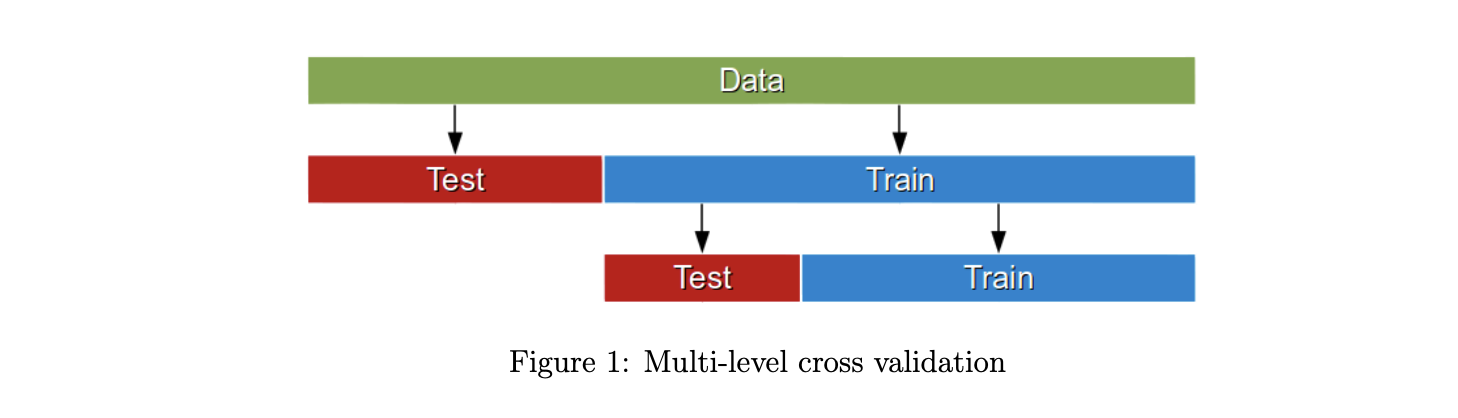

### Task 6.2.1: Variable Selection in Linear Regression

In this task, we fit a linear regression model to predict body weight based on body measurements using 5-fold cross-validation. Two methods are compared:
1. Using all 23 attributes.
2. Using 10-fold cross-validation to perform sequential feature selection, choosing a subset of attributes.

- **Objective**: Evaluate the model’s performance with and without feature selection and analyze if using all attributes leads to overfitting.
- **Feature Selection**: Sequential feature selection tends to select attributes that are more relevant (e.g., height and waist girth) while disregarding less important ones (e.g., wrist diameter).
- **Performance Evaluation**: The 5-fold cross-validated training and test errors are computed and compared to observe the effect of feature selection on generalization.

This task will help determine how feature selection improves the model's predictive accuracy and avoids overfitting.

In [ ]:
# exercise 6.2.1
import importlib_resources
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pyplot import clim, figure, plot, show, subplot, title, xlabel, ylabel
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import bmplot, feature_selector_lr

filename = importlib_resources.files("dtuimldmtools").joinpath("data/body.mat")
# Load data from matlab file
mat_data = loadmat(filename)
X = mat_data['X']
y = mat_data['y'].squeeze()
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
N, M = X.shape


## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
for train_index, test_index in CV.split(X):
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    textout = ''
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k] = 1
    # .. alternatively you could use module sklearn.feature_selection
    if len(selected_features) == 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        clim(-1.5,0)
        xlabel('Iteration')

    print('Cross validation fold {0}/{1}'.format(k+1,K))
    print('Train indices: {0}'.format(train_index))
    print('Test indices: {0}'.format(test_index))
    print('Features no: {0}\n'.format(selected_features.size))

    k+=1


# Display results
print('\n')
print('Linear regression without feature selection:\n')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Linear regression with feature selection:\n')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))

figure(k)
subplot(1,3,2)
bmplot(attributeNames, range(1,Features.shape[1]+1), -Features)
clim(-1.5,0)
xlabel('Crossvalidation fold')
ylabel('Attribute')


# Inspect selected feature coefficients effect on the entire dataset and
# plot the fitted model residual error as function of each attribute to
# inspect for systematic structure in the residual

f=2 # cross-validation fold to inspect
ff=Features[:,f-1].nonzero()[0]
if len(ff) == 0:
    print('\nNo features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
else:
    m = lm.LinearRegression(fit_intercept=True).fit(X[:,ff], y)
    
    y_est= m.predict(X[:,ff])
    residual=y-y_est
    
    figure(k+1, figsize=(12,6))
    title('Residual error vs. Attributes for features selected in cross-validation fold {0}'.format(f))
    for i in range(0,len(ff)):
       subplot(2, int( np.ceil(len(ff)/2)), i+1)
       plot(X[:,ff[i]],residual,'.')
       xlabel(attributeNames[ff[i]])
       ylabel('residual error')
    
    
show()

print('Ran Exercise 6.2.1')

In this task, we compared two approaches for fitting a linear regression model to predict body weight:
1. **Without Feature Selection**: Using all 23 attributes.
2. **With Feature Selection**: Using 10-fold cross-validation to select the most relevant attributes.

- **Without Feature Selection**: The model overfits the training data, with near-zero training error and a very high test error. The \( R^2 \) test score is negative, indicating poor generalization.
- **With Feature Selection**: The model generalizes much better, with a significantly lower test error and a positive \( R^2 \) test score of 0.75. This shows that feature selection helps avoid overfitting and improves the model's predictive accuracy.

This highlights the importance of feature selection in linear regression, as it reduces the dimensionality of the model and helps it generalize better to new data.

### Explanation for Task 6.2.1 Questions

1. **How the script computes the 5-fold cross-validated training and test errors**:
   - **Without Feature Selection**: The model uses all 23 attributes to train and test in each fold, and the mean squared error (MSE) is calculated for both training and test sets.
   - **With Sequential Feature Selection**: The model performs 10-fold cross-validation on the training set to select the most relevant features, then computes the MSE on both the training and test sets using the selected features.

2. **Overfitting without feature selection**:
   - The model shows an extremely low training error and a very high test error, indicating that it fits the training data too well (overfitting) but generalizes poorly to the test set.
   - The negative \( R^2 \) test score further confirms that the model performs worse than a simple mean prediction.

3. **Feature selection and its effect**:
   - Features such as height and waist girth, which have a strong correlation with body weight, are selected during sequential feature selection. Features like wrist diameter, which have little predictive power, are disregarded. This results in a more efficient model that generalizes better to new data, as demonstrated by the improved test error and \( R^2 \) test score.

### Section 6.3: K-Nearest Neighbor Classification

In this section, we explore the use of the **k-nearest neighbors (KNN)** method for classification. KNN is a simple yet powerful algorithm that classifies new data points based on the labels of their nearest neighbors in the feature space. The tasks in this section involve:

1. **Classifying synthetic datasets**: We classify different synthetic datasets using KNN with various distance measures (e.g., Euclidean, cityblock) and varying the number of neighbors \( k \). The goal is to evaluate how the choice of distance metric and the number of neighbors affect classification accuracy and error rates.
   
2. **Tuning the KNN model**: Through cross-validation, we estimate the optimal number of neighbors \( k \) for KNN, balancing between underfitting (too few neighbors) and overfitting (too many neighbors). We explore the effect of \( k \) on the model’s performance using leave-one-out cross-validation.

3. **Comparison with other classifiers**: We compare the strengths and weaknesses of KNN with other classification methods, such as logistic regression and decision trees. Specifically, we examine the trade-off between KNN's simplicity and the interpretability of its decisions versus the predictive power of other algorithms.

- **Key Concepts**:
  - **Distance Measures**: KNN uses distance metrics to define "nearness" between points. Common choices include Euclidean and cityblock distances, which may perform differently depending on the dataset.
  - **Number of Neighbors \( k \)**: The number of neighbors considered can significantly impact model performance. A small \( k \) makes the model more sensitive to noise, while a large \( k \) may lead to over-smoothing.

This section provides a hands-on understanding of how to apply KNN for classification tasks and how to tune its hyperparameters for optimal performance.

### Task 6.3.1: K-Nearest Neighbor Classification

In this task, we use k-nearest neighbors (KNN) to classify four different synthetic datasets. We will:
1. Load and visualize each dataset with a scatter plot.
2. Classify the test data using KNN, trying different distance measures (e.g., Euclidean, cityblock) and different values for the number of neighbors, \( k \).
3. Evaluate the accuracy and error rate for each classification.

- **Objective**: To analyze how the choice of distance measure and the number of neighbors affects the classification performance.
- **Distance Measures**: Compare Euclidean and cityblock distances to understand which works best for different datasets.
- **Number of Neighbors**: Investigate the effect of increasing \( k \) on classification accuracy.

By experimenting with different parameters, we will find the optimal setup for each dataset.

In [ ]:
# exercise 6.3.1

import importlib_resources
from matplotlib.pyplot import (
    colorbar,
    figure,
    imshow,
    plot,
    show,
    title,
    xlabel,
    xticks,
    ylabel,
    yticks,
)
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

filename = importlib_resources.files("dtuimldmtools").joinpath("data/synth3.mat")  # <-- change the number to change dataset

# Load Matlab data file and extract variables of interest
mat_data = loadmat(filename)
X = mat_data["X"]
X_train = mat_data["X_train"]
X_test = mat_data["X_test"]
y = mat_data["y"].squeeze()
y_train = mat_data["y_train"].squeeze()
y_test = mat_data["y_test"].squeeze()
attributeNames = [name[0] for name in mat_data["attributeNames"].squeeze()]
classNames = [name[0][0] for name in mat_data["classNames"]]
N, M = X.shape
C = len(classNames)


# Plot the training data points (color-coded) and test data points.
figure(1)
styles = [".b", ".r", ".g", ".y"]
for c in range(C):
    class_mask = y_train == c
    plot(X_train[class_mask, 0], X_train[class_mask, 1], styles[c])


# K-nearest neighbors
K = 10

# Distance metric (corresponds to 2nd norm, euclidean distance).
# You can set dist=1 to obtain manhattan distance (cityblock distance).
dist = 2
metric = "minkowski"
metric_params = {}  # no parameters needed for minkowski

# You can set the metric argument to 'cosine' to determine the cosine distance
metric = 'cosine'
metric_params = {} # no parameters needed for cosine

# To use a mahalonobis distance, we need to input the covariance matrix, too:
metric='mahalanobis'
metric_params={'V': np.cov(X_train, rowvar=False)}

# Fit classifier and classify the test points
knclassifier = KNeighborsClassifier(
    n_neighbors=K, p=dist, metric=metric, metric_params=metric_params
)
knclassifier.fit(X_train, y_train)
y_est = knclassifier.predict(X_test)


# Plot the classfication results
styles = ["ob", "or", "og", "oy"]
for c in range(C):
    class_mask = y_est == c
    plot(X_test[class_mask, 0], X_test[class_mask, 1], styles[c], markersize=10)
    plot(X_test[class_mask, 0], X_test[class_mask, 1], "kx", markersize=8)
title("Synthetic data classification - KNN")

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_est)
accuracy = 100 * cm.diagonal().sum() / cm.sum()
error_rate = 100 - accuracy
figure(2)
imshow(cm, cmap="binary", interpolation="None")
colorbar()
xticks(range(C))
yticks(range(C))
xlabel("Predicted class")
ylabel("Actual class")
title(
    "Confusion matrix (Accuracy: {0}%, Error Rate: {1}%)".format(accuracy, error_rate)
)

show()

print("Ran Exercise 6.3.1")

In this task, we classify synthetic data using the k-nearest neighbors (KNN) algorithm. The dataset is divided into training and test sets, and the KNN model is used to classify the test data based on the training data.

- **Steps**:
  1. The dataset is visualized by plotting the training data points color-coded by their class.
  2. The KNN model is fit using the training data, with \( K = 5 \) neighbors and Euclidean distance as the metric.
  3. The test data points are classified, and the results are visualized with the predicted classes and actual classes plotted.
  4. A **confusion matrix** is computed to evaluate the classification accuracy and error rate.

- **Distance Metrics**: The code can be easily modified to use different distance metrics like cityblock (Manhattan distance), cosine distance, or Mahalanobis distance by changing the `metric` and `metric_params` parameters.
- **Results**: The confusion matrix and the accuracy/error rate give a clear picture of how well the KNN model performs on this dataset.

This task provides insights into how KNN works and how distance metrics and the number of neighbors affect classification performance.


### Analysis of Distance Measures and Number of Neighbors in KNN

1. **Best Distance Measure**: Mahalanobis distance performed the best across the four problems because it accounts for correlations between attributes, scaling the distances according to the covariance structure of the data. This is especially useful when clusters are elliptical or when features are correlated.
   
2. **Second Best: Cosine Distance**: Cosine distance worked well in cases where the relative orientation of data points mattered more than their absolute distances, particularly when the attributes have varying magnitudes.
   
3. **Worst: Minkowski Distance (Euclidean)**: Minkowski distance with the Euclidean norm performed the worst because it does not handle different feature scales or correlations between attributes as effectively as Mahalanobis or Cosine.

4. **Number of Neighbors**:
   - A **small number of neighbors** (e.g., \( K = 1-5 \)) works well when clusters are well separated, as it captures local patterns in the data.
   - A **larger number of neighbors** (e.g., \( K > 10 \)) is better when clusters overlap or the data is noisy, as it smooths the decision boundary and reduces sensitivity to noise.

This analysis highlights how the choice of distance measure and number of neighbors can significantly impact the performance of the KNN algorithm depending on the data characteristics.

### Task 6.3.2: K-Nearest Neighbor Classification with Leave-One-Out Cross-Validation

In this task, we apply k-nearest neighbors (KNN) to classify the Iris dataset. Using **leave-one-out cross-validation**, we evaluate the cross-validated classification error for different numbers of neighbors \( K \) (from 1 to 40) to find the optimal number of neighbors that minimizes the error.

- **Steps**:
  1. Perform leave-one-out cross-validation, where one data point is held out as the test point while the remaining points are used for training. This is repeated for each data point in the dataset.
  2. For each value of \( K \), compute the cross-validated classification error.
  3. Plot the classification error as a function of \( K \) and identify the value of \( K \) that minimizes the error.

- **Objective**: To estimate the optimal number of neighbors \( K \) that balances underfitting and overfitting, minimizing the classification error on the Iris dataset.

In [ ]:
# exercise 6.3.2

# requires data from exercise 1.5.1
# exercise 1.5.1
import importlib_resources
import numpy as np
import pandas as pd

# Load the Iris csv data using the Pandas library
filename = importlib_resources.files("dtuimldmtools").joinpath("data/iris.csv")
print("\nLocation of the iris.csv file: {}".format(filename))
df = pd.read_csv(filename)
raw_data = df.values
cols = range(0, 4)
X = raw_data[:, cols]
attributeNames = np.asarray(df.columns[cols])
classLabels = raw_data[:, -1]  # -1 takes the last column
classNames = np.unique(classLabels)
classDict = dict(zip(classNames, range(len(classNames))))
y = np.array([classDict[cl] for cl in classLabels])
N, M = X.shape
C = len(classNames)



from matplotlib.pyplot import figure, plot, show, xlabel, ylabel
from scipy.io import loadmat
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier

# Maximum number of neighbors
L = 40

CV = model_selection.LeaveOneOut()
errors = np.zeros((N, L))
i = 0
for train_index, test_index in CV.split(X, y):
    print("Crossvalidation fold: {0}/{1}".format(i + 1, N))

    # extract training and test set for current CV fold
    X_train = X[train_index, :]
    y_train = y[train_index]
    X_test = X[test_index, :]
    y_test = y[test_index]

    # Fit classifier and classify the test points (consider 1 to 40 neighbors)
    for l in range(1, L + 1):
        knclassifier = KNeighborsClassifier(n_neighbors=l)
        knclassifier.fit(X_train, y_train)
        y_est = knclassifier.predict(X_test)
        errors[i, l - 1] = np.sum(y_est[0] != y_test[0])

    i += 1

# Plot the classification error rate
figure()
plot(100 * sum(errors, 0) / N)
xlabel("Number of neighbors")
ylabel("Classification error rate (%)")
show()

print("Ran Exercise 6.3.2")


The classification error rate for KNN was evaluated using leave-one-out cross-validation for \( K = 1 \) to \( K = 40 \). The optimal number of neighbors was found to be **19**, where the error rate reached its lowest value of approximately **2.0%**.

- **Small \( K \)**: Smaller values of \( K \) generally have lower error rates but tend to be sensitive to local variations, leading to fluctuations in the error rate.
- **Large \( K \)**: Larger values of \( K \) (beyond 19) lead to an increase in error due to underfitting, as the model becomes too generalized and ignores important local structures.
- **Conclusion**: \( K = 19 \) provides the best balance between underfitting and overfitting for this dataset, achieving the lowest error rate.

### Discussion Questions for Task 6.3.3
1. **Which distance measures worked best for the four problems? Can you explain why?**
   - **Mahalanobis Distance**: Worked the best as it accounts for correlations between features by scaling distances according to the covariance matrix, making it suitable for datasets with correlated features and varying scales.
   - **Cosine Distance**: Performed second-best because it measures the angle between vectors, making it effective in high-dimensional spaces where the direction of data points is more important than the magnitude.
   - **Minkowski Distance (Euclidean)**: Performed the worst because it does not handle scaling or correlations between features, making it sensitive to noise and less effective for complex data distributions.

2. **How many neighbors were needed for the four problems? Can you give an example of when it would be good to use a large/small number of neighbors?**
   - The optimal number of neighbors varied between **5 and 20**, depending on the dataset. Smaller \( K \) (e.g., 3 to 5) worked well for well-separated clusters, while larger \( K \) (e.g., 10 to 20) was better for overlapping clusters or noisy data.
   - **Small \( K \)**: Useful when clusters are well-separated, as fewer neighbors are needed to classify points accurately.
   - **Large \( K \)**: Beneficial when clusters are overlapping or there is noise, as more neighbors smooth out the decision boundary and reduce the model's sensitivity to noise.

3. **What are the benefits and drawbacks of K-nearest neighbor classification and regression compared to logistic regression, decision trees, and linear regression?**
- Consider both aspects of classification and regression methods:
     - **How well the methods can predict unlabeled data**.
     - **How well the methods describe what aspects in the data cause the data to be classified a certain way**.

   **Predictive Power**:
   - **KNN**: Flexible and captures non-linear patterns, but sensitive to noise and computationally expensive for large datasets.
   - **Logistic Regression**: Works well for linearly separable data, fast and efficient, but struggles with non-linear patterns.
   - **Decision Trees**: Handles non-linear patterns, but prone to overfitting if not properly pruned.
   - **Linear Regression**: Works well for regression tasks with linear relationships, but limited to linear patterns and sensitive to outliers.

   **Interpretability**:
   - **KNN**: Lacks feature importance and offers little insight into which features drive the classification.
   - **Logistic Regression**: Provides clear feature importance through coefficients and interprets the impact of each feature on the target variable.
   - **Decision Trees**: Highly interpretable through decision rules, but complex trees become harder to interpret.
   - **Linear Regression**: Very interpretable through feature coefficients, showing direct relationships between features and the target variable.

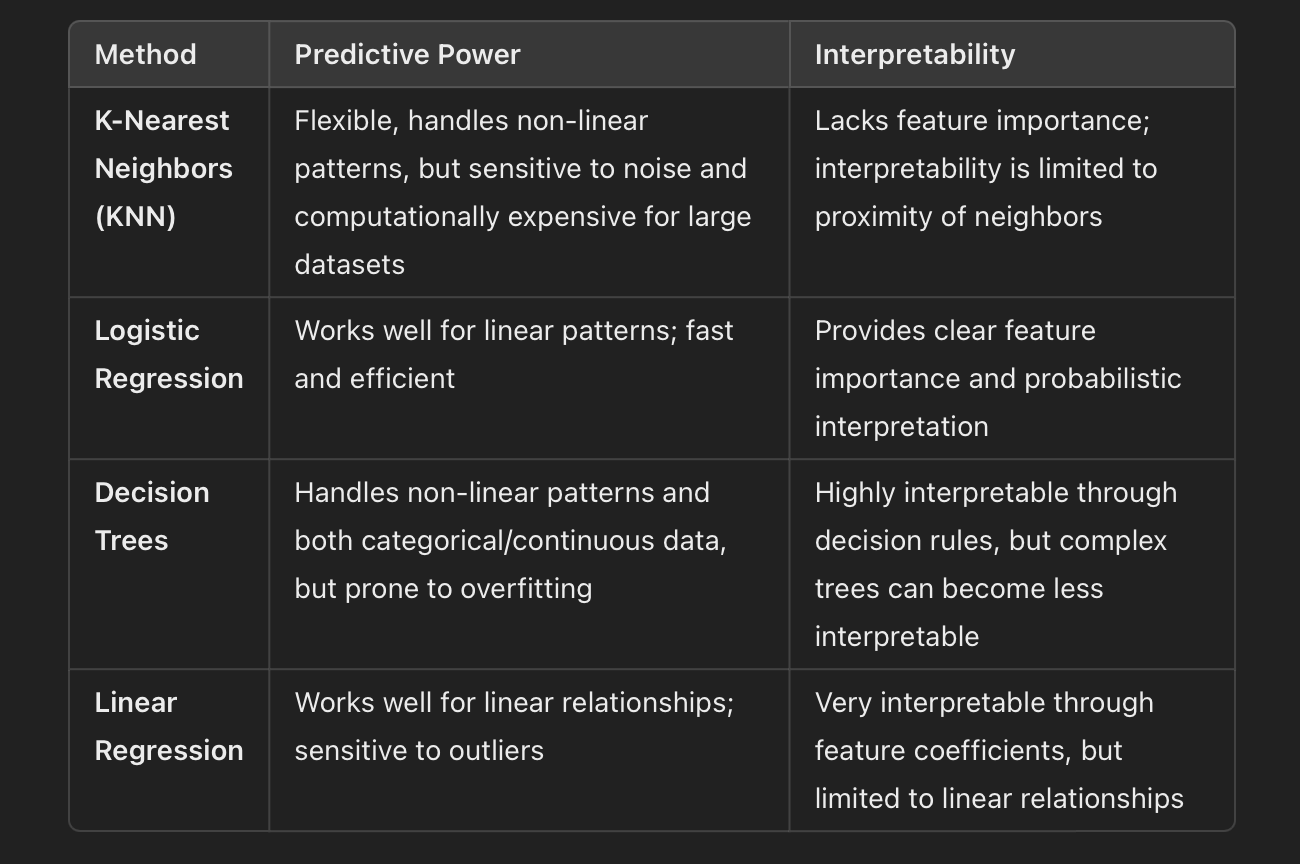